# FFT and Polynomial Multiplication

Here, you will implement FFT, and then use FFT as a black box to some applied problems.


__Note that the functions you write build upon one another. Therefore, it will be necessarily to correctly solve previous problems in the notebook to solve later problems.__

In [4]:
# Install dependencies
!pip install -r requirements.txt --quiet

In [5]:
import otter
import scipy

assert (
    otter.__version__ >= "4.4.1" and scipy.__version__ >= "1.10.0"
), "Please reinstall the requirements and restart your kernel."

grader = otter.Notebook("fft.ipynb")
import numpy as np
from numpy.random import randint
from time import time
import tqdm
import scipy
import matplotlib.pyplot as plt
import numpy.random as random

rng_seed = 0

##### If you're using Datahub:
* Run the cell below **and restart the kernel if needed**

##### If you're running locally:
* Make sure you've activated the conda environment: `conda activate cs170`
* Launch jupyter: `jupyter notebook` or `jupyter lab` 
* Run the cell below **and restart the kernel if needed**

### Q1.1) Roots of Unity
$n$-th roots of unity are defined as complex numbers where $z^n=1$.  
Another equivalent definition is the numbers $e^{\frac{2\pi ik}{n}}$ where $k={0, 1, \cdots, n-1}$.  
First, write a function that, given $n$, outputs all $n$-th roots of unity. Note that $n$ does not have to be even.
 
You can alternatively calculate it in form $a+bi$, but it is not required.

*Hints:* 
1. There are multiple ways to calculate roots of unity. You may find the following constants and functions useful. Depending on how you choose to complete this part, you may not need all of them:
    * `np.e`
    * `np.pi`
    * `np.exp()`
    * `np.zeros()`
    * `np.roots()` 
2. If you're unsure of what a particular function does, you can always consult the appropriate Numpy/Scipy/Python documentation or type `?` followed by a function name in a notebook cell to get more information. For example, `?np.exp` will give you more information about the `np.exp()` function. 

3. Python supports arithmetic with complex numbers. You can enter complex literals in the form `a + bj` where `a` and `b` are integers. For example, you can have `2 + 3j`. If you want to cast a real number to a complex type, you need to write something like `1 + 0j` or `complex(1)`.

4. Make sure you return the roots in the correct order: if the principal root is $\omega$, you should return  $[1, \omega, \omega^2, \omega^3, \dots]$. 

In [6]:
def roots_of_unities(n):
    """
    args:
        n:int = n describes which root of unity to return
    return:
        a list of n complex numbers containing the n-th roots of unity [w^0, w^1, w^2, ..., w^{n-1}]
    """
    '''roots_of_unity = []
    w = np.exp(  )
    for i in range(n):
        roots_of_unity.append(pow(w,i))
    return roots_of_unity
    '''
    return np.exp(1j * 2 * np.pi / n * np.arange(n)) 

To make sure your helper function is correct, we can draw the resulting values on the unit circle. Run the following cell and make sure the output is as you expect it to be:

_Points:_ 0.5

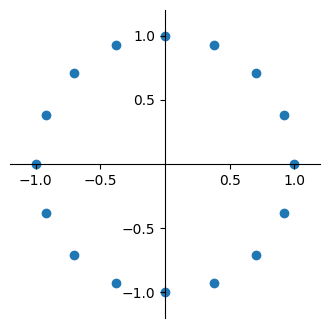

In [7]:
N = 16  # feel free to change this value and observe what happens
roots = roots_of_unities(N)

# Plot
f, ax = plt.subplots()
f.set_figwidth(4)
f.set_figheight(4)
plt.scatter([r.real for r in roots], [r.imag for r in roots])
ax.spines["left"].set_position("zero")
ax.spines["right"].set_color("none")
ax.yaxis.tick_left()
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_color("none")
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_xticks([-1, -0.5, 0.5, 1])
ax.set_yticks([-1, -0.5, 0.5, 1])
ax.xaxis.tick_bottom()

In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

## Discrete Fourier Transform
In CS170, we define the process that transforms polynomials from coefficient representation to value representation (at next $2^n$-th roots of unities) as "Discrete Fourier Transform".  
For example, for polynomial $P(x)=1+x+x^2+x^3$, its value representation would be $P(1)=4, P(i)=0, P(-1)=0, P(-i)=0$.  

### Q1.2) Naive DFT
Write an naive algorithm that calculated DFT.  

*Hints:*
1. The input list is a list of coefficients but you might find `np.poly1d` useful. https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html 
2. You might find the following function useful.

_Points:_ 1

In [9]:
# Utility function, returns next 2^n
hyperceil = lambda x: int(2 ** np.ceil(np.log2(x)))

In [10]:
def dft_naive(coeffs):
    """
    args:
        coeffs:np.array = list of numbers representing the coefficients of a polynomial where coeffs[i]
                    is the coeffiecient of the term x^i
    return:
        List containing the results of evaluating the polynomial at the roots of unity. Can be either a list or np.array
        [P(w_0), P(w_1), P(w_2), ...]
    """
    n = len(coeffs)
    p = np.poly1d(np.flip(coeffs))
    return p(roots_of_unities(n))

In [11]:
grader.check("q1.2")

100%|██████████| 50/50 [00:00<00:00, 303.15it/s]


q1.2 results: All test cases passed!

### Q1.3) FFT

FFT is an algorithm that calculates DFT in $\mathcal{O}(n \log n)$ time.

Now, you'll implement FFT by itself.  The way it is defined here, this takes in the coefficients of a polynomial as input, evaluates it on the $n$-th roots of unity, and returns the list of these values.  For instance, calling 

$$
FFT([1, 2, 3, 0], \; [1, i, -1, -i])
$$

should evaluate the polynomial $1 + 2x + 3x^2$ on the points $1, i, -1, -i$, returning

$$
[6, \; -2 + 2i, \; 2, \; -2 - 2i]
$$

Recall that to do this efficiently for a polynomial 

$$
P(x) = a_0 + a_1x + a_2x^2 + \cdots + a_{n - 1} x^{n - 1}
$$

we define two other polynomials $E$ and $O$, containing the coefficients of the even and odd degree terms respectively,

$$
E(x) := a_0 + a_2x + \cdots + a_{n - 2}x^{n/2 - 1}, \qquad O(x) := a_1 + a_3x + \cdots = a_{n - 1}x^{n/2 - 1}
$$

which satisfy the relation

$$
P(x) = E(x^2) + xO(x^2)
$$

We recursively run FFT on $E$ and $O$, evaluating them on the $n/2$-th roots of unity, then use these values to evaluate $P$ on the $n$-th roots of unity, via the above relation.

Implement this procedure below, where $\text{``coeffs''}$ are the coefficients of the polynomial we want to evaluate (with the coefficient of $x^i$ at index $i$), and where  

$$
\text{roots} = [1, \omega, \omega^2, \ldots, \omega^{n - 1}]
$$

for some primitive $n$-th root of unity $\omega$ where $n$ is a power of $2$.  (Note:  Arithmetic operations on complex numbers in python work just like they do for floats or ints.  Also, you can use $\text{A[::k]}$ to take every $k$-th element of an array A)

*Debugging tip:*
1. Remember that your inputs are `np.array`s. Unless you specifically cast to `List`, you can't append or concatenate `np.array`s in the same way as Python lists. You can use `np.append` to append to an array, and `np.concatenate` to concatenate two `np.array`s.

In [12]:
def fft(coeffs, roots):
    """
    args:
        coeffs (np.array): array of numbers representing the coefficients of a polynomial where coeffs[i]
                    is the coeffiecient of the term x^i
        roots (np.array): array containing the roots of unity [w_0, w_1, w_2, ..., w_{n-1}]
    return:
        List containing the results of evaluating the polynomial at the roots of unity
        [P(w_0), P(w_1), P(w_2), ...]
    """
    coeffs, roots = np.array(coeffs), np.array(roots)
    
    n = len(coeffs)
    assert n == hyperceil(n)
    # base case
    if n == 1:
        return coeffs
    
    coeffs_e, coeffs_o= coeffs[::2], coeffs[1::2]
    new_roots = roots[::2]
    y_e, y_o = fft(coeffs_e, new_roots), fft(coeffs_o, new_roots)
    
    return np.concatenate((y_e + roots[:n//2] * y_o, y_e + roots[n//2:] * y_o), axis=None)
    
    

### Testing

Here's a sanity check to test your implementation.  Calling $FFT([1, 2, 3, 0], [1, 1j, -1, -1j])$ should output $[6, \; -2 + 2j, \; 2, \; -2 - 2j]$ (Python uses $j$ for the imaginary unit instead of $i$.)

Feel free to add your own testing cells here as well!

In [13]:
expected = [6, -2 + 2j, 2, -2 - 2j]
actual = fft([1, 2, 3, 0], [1, 1j, -1, -1j])
assert np.allclose(expected, actual), f"expected: {expected}\n actual: {actual}"
print("success")

success


If you correctly implemented the FFT algorithm, and aren't naively evaluating on each point, the result should only work when the `roots` parameter are the roots of unity. Therefore, the call $FFT([1, 2, 3, 0], [1, 2, 3, 4])$ should NOT return the values of $1 + 2x + 3x^2$ on the inputs $[1, 2, 3, 4]$ (which would be $[6, 17, 34, 57]$):

_Points:_ 3

In [14]:
not_expected = [6, 17, 34, 57]
actual = fft([1, 2, 3, 0], [1, 2, 3, 4])
assert not np.allclose(expected, actual), f"NOT expected: {expected}\n actual: {actual}"
print("success")

success


In [15]:
grader.check("q1.3")

testing correctness...


100%|██████████| 100/100 [00:00<00:00, 152.37it/s]


testing speed...


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


q1.3 results: All test cases passed!

### Q1.4) Inverse FFT
Now that you know your FFT is correct, implement IFFT.  

IFFT can be implemented in less than 3 lines, you can check the bottom of DPV page 75 to see how it is finished.


*Hints:*
1. Python supports computing the inverse of a complex number by raising it to the power of $-1$. In other words, suppose `x` is a complex number, the inverse is `x**(-1)`.
2. We pass in `roots` as a parameter for a reason, make sure you use it instead of hardcoding your roots of unity in both your `fft` and `ifft` functions.

_Points:_ 1.5

In [21]:
def ifft(vals, roots):
    """
    args:
        val (np.array): numpy array containing the results of evaluating the polynomial at the roots of unity
                    [P(w_0), P(w_1), P(w_2), ...]

        roots (np.array): numpy array containing the roots of unity [w_0, w_1, w_2, ..., w_{n-1}]

    return:
        List containing the results of evaluating the polynomial at the roots of unity. Can be a Python list
            or numpy array.
        [P(w_0), P(w_1), P(w_2), ...]
    """
    vals, roots = np.array(vals), np.array(roots)
    
    n = len(vals)
    assert n == hyperceil(n)
    
    inverse_roots = roots**(-1)
    return 1 / n * fft(vals, inverse_roots)
    

In [18]:
grader.check("q1.4")

testing correctness...


100%|██████████| 100/100 [00:01<00:00, 87.41it/s]


testing speed...


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


q1.4 results: All test cases passed!

## Q1.5) Polynomial Multiplication (Optional)

### The following subpart is optional and ungraded, but you may find it helpful for understanding how FFT is used to perform polynomial multiplication.

Now you'll implement polynomial multiplication, using your FFT function as a black box.  Recall that to do this, we first run FFT on the coefficients of each polynomial to evaluate them on the $n$-th roots of unity for a sufficiently large power of 2,  which we call $n$.  We then multiply these values together pointwise, and finally run the inverse FFT on these values to convert back to coefficient form, obtaining the coefficient of the product.  To perform inverse FFT, we can simply run FFT, but with the roots of unity inverted, and divide by $n$ at the end.

Note that FFT and IFFT only accepts polynomials of degree $2^n-1$, so you would need to pad coefficients to the next `hyperceil(n)`. 

You may find defining the `pad` function to be helpful but are not required to do so.

_Points:_ 0

In [86]:
def pad(coeffs, to):
    """
    args:
        coeffs:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i]
                    is the coeffiecient of the term x^i
        to:int = the final length coeffs should be after padding

    return:
        List of coefficients zero padded to length 'to'
    """
    return np.concatenate((coeffs, np.zeros(to - len(coeffs))))
    # return coeffs + [0] * (to - len(coeffs))


def poly_multiply(coeffs1, coeffs2):
    """
    args:
        coeffs1:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i]
                    is the coeffiecient of the term x^i
        coeffs2:List[] = list of numbers representing the coefficients of a polynomial where coeffs[i]
                    is the coeffiecient of the term x^i

    return:
        List of coefficients corresponding to the product polynomial of the two inputs.
    """
    coeffs1, coeffs2 = np.array(coeffs1), np.array(coeffs2)
    
    n, m = len(coeffs1), len(coeffs2)
    final_len = n + m - 1
    to = hyperceil(final_len)
    coeffs1, coeffs2 = pad(coeffs1, to), pad(coeffs2, to) # pad coe1, coe2 to 2^k > n+m-1
    
    roots = roots_of_unities(to)
    
    P, Q = fft(coeffs1, roots), fft(coeffs2, roots)
    
    return ifft(P*Q, roots)

### Testing

In [69]:
def round_complex_to_int(lst):
    return [round(x.real) for x in lst]


def zero_pop(lst):
    return np.trim_zeros(lst, "b")

Here are a couple sanity checks for your solution.

In [87]:
expected = [4, 13, 22, 15]
actual = round_complex_to_int(poly_multiply([1, 2, 3], [4, 5]))
print("expected: {}".format(expected))
print("actual:   {}\n".format(actual))

expected = [4, 13, 28, 27, 18, 0, 0, 0]
actual = round_complex_to_int(poly_multiply([1, 2, 3], [4, 5, 6]))
print("expected: {}".format(expected))
print("actual:   {}".format(actual))

AssertionError: 

One quirk of FFT is that we use complex numbers to multiply integer polynomials, so this leads to floating point errors.  You can see this with the following call, which will probably not return exact integer values (unless you did something in your implementation to handle this):

In [65]:
result = poly_multiply([1, 2, 3], [4, 5, 6])
result

array([4.00000000e+00+2.08251854e-15j, 1.30000000e+01+8.80756495e-16j,
       2.80000000e+01-4.29245360e-16j, 2.70000000e+01-9.26526005e-16j,
       1.80000000e+01-6.12942380e-16j, 1.77635684e-15-1.33968955e-15j,
       1.77635684e-15-3.05542719e-16j, 0.00000000e+00-2.70288284e-15j])

Therefore, if we're only interested in integers, like many of the homework problems, we have to round the result:

In [26]:
result = round_complex_to_int(result)
result

[4, 13, 28, 27, 18, 0, 0, 0]

However, there might still be trailing zeros we have to remove:

In [27]:
zero_pop(result)

[4, 13, 28, 27, 18]

This (hopefully) gives us exactly what we would have gotten by multiplying the polynomials normally, $[4, 13, 28, 27, 18]$.

### Runtime Comparison

Here, we compare the runtime of polynomial multiplication with FFT to the naive algorithm.

In [28]:
def poly_multiply_naive(coeffs1, coeffs2):
    n1, n2 = len(coeffs1), len(coeffs2)
    n = n1 + n2 - 1
    prod_coeffs = [0] * n
    for deg in range(n):
        for i in range(max(0, deg + 1 - n2), min(n1, deg + 1)):
            prod_coeffs[deg] += coeffs1[i] * coeffs2[deg - i]
    return prod_coeffs

In [29]:
poly_multiply_naive([3, 4, 5], [7, 2, 7, 4])

[21, 34, 64, 50, 51, 20]

Running the following cell, you should see FFT perform similarly to or worse than the naive algorithm on small inputs, but perform significantly better once inputs are sufficiently large, which should be apparent by how long you have to wait for the naive algorithm to finish on the largest input (you might need to run the next cell twice to see the plot for some reason):


size: 10
FFT time:   0.001000
naive time: 0.000000
speed up: 0.000000

size: 100
FFT time:   0.007001
naive time: 0.001000
speed up: 0.142852

size: 1000
FFT time:   0.060378
naive time: 0.074156
speed up: 1.228195

size: 10000
FFT time:   0.977435
naive time: 7.595329
speed up: 7.770677


Text(0.5, 1.0, 'FFT Polynomial Multiplication Speedup')

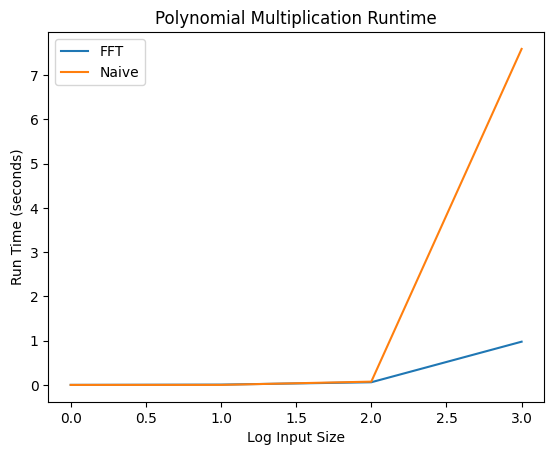

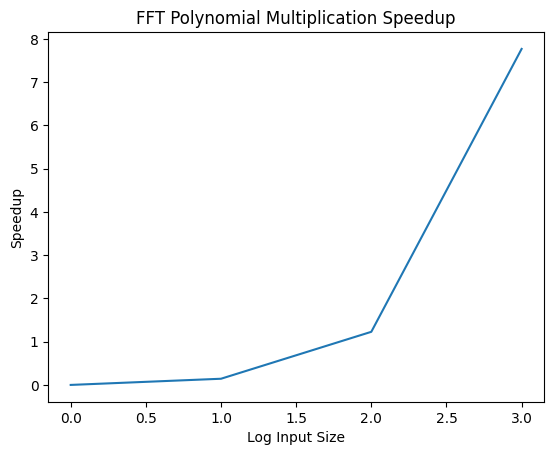

In [30]:
def rand_ints(lo, hi, length):
    ints = list(randint(lo, hi, length))
    ints = [int(x) for x in ints]
    return ints


def record(array, value, name):
    array.append(value)
    print("%s%f" % (name, value))


fft_times = []
naive_times = []
speed_ups = []

for i in range(1,5):
    n = 10**i
    print("\nsize: %d" % n)
    poly1 = rand_ints(1, 100, n)
    poly2 = rand_ints(1, 100, n)
    time1 = time()
    fft_res = poly_multiply(poly1, poly2)
    fft_res = zero_pop(round_complex_to_int(fft_res))
    time2 = time()
    fft_time = time2 - time1
    record(fft_times, fft_time, "FFT time:   ")
    naive_res = poly_multiply_naive(poly1, poly2)
    time3 = time()
    naive_time = time3 - time2
    record(naive_times, naive_time, "naive time: ")
    assert fft_res == naive_res
    speed_up = naive_time / fft_time
    record(speed_ups, speed_up, "speed up: ")

plt.plot(fft_times, label="FFT")
plt.plot(naive_times, label="Naive")
plt.xlabel("Log Input Size")
plt.ylabel("Run Time (seconds)")
plt.legend(loc="upper left")
plt.title("Polynomial Multiplication Runtime")

plt.figure()
plt.plot(speed_ups)
plt.xlabel("Log Input Size")
plt.ylabel("Speedup")
plt.title("FFT Polynomial Multiplication Speedup")

## Q2) Evaluating Predictions
Now, let's see how we can apply FFT to speed up a common signal-processing task.

Suppose we have access to the temperature for the past $n$ days, where  $y_0, y_1, \ldots, y_{n-1}$ where all $y_i \in \R$.
You are given fixed coefficients $c_0, \ldots, c_{n-2}$, which give the following prediction for day $t \geq 1$:
$$p_t = \sum_{k=0}^{t-1} c_{k} y_{t-1-k}$$

Note that we only compute $p_t$ for $t > 0$. 

You would like to evaluate the accuracy of this prediction on the dataset
by computing the $\textit{mean squared error}$, given by
$$ \frac{1}{n-1} \sum_{t=1}^{n-1} (p_t - y_t)^2$$

Find an $\mathcal{O}(n \log n)$ time algorithm to compute the mean squared error, 
given dataset $y_0, y_1, \ldots, y_{n-1}$ and coefficients $c_0, \ldots, c_{n-2}$. 

You may use any functions that you implemented previously, and you may also find it helpful (but are not required) to implement and use the `pad` function defined below. For this subpart, you may also use numpy or scipy FFT and iFFT.

*Hints:*

1. Try walking through the computation of $p_t$ by hand. If we want to cast this as polynomial multiplication, do we need to modify the coefficients $c_0, \ldots, c_{n-2}$ in any way? 
2. What about the dataset $y_0, y_1, \ldots, y_{n-1}$? 

_Points:_ 5

In [53]:
# def pad(coeffs, to):
#   """
#    args:
#        coeffs (np.array): list of numbers representing the coefficients of a polynomial where coeffs[i]
#                    is the coeffiecient of the term x^i
#        to (int): the final length coeffs should be after padding
#
#    return:
#        List of coefficients zero padded to length 'to'
#    """
#    ...


def evaluate_predictions(coeffs, labels):
    """Given coefficients and labels, generate predictions for each day and return the MSE between the
        predictions and the labels. See the formulas in the problem for specific details on how these
        are defined.

    Args:
        coeffs (np.array): Fixed coefficients c_0, c_1, ..., c_{n-2} which are used to generate the predictions
        labels (np.array): List of temperatures for the past n days, y_0, y_1, ..., y_{n-1}
    Returns:
        int: MSE between the predictions and the labels over all n-1 days.
    """
    
    # p_t is the coefficient of coeffs*lables' degree t-1.
    n = len(labels)
    pred = poly_multiply(coeffs, labels)[:n-1]
    return np.mean((pred - labels[1:]) ** 2)

In [66]:
grader.check("q2")

testing correctness...


100%|██████████| 500/500 [00:02<00:00, 226.83it/s]


testing speed...


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


q2 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [67]:
grader.export(pdf=False, force_save=True, run_tests=True)

<IPython.core.display.Javascript object>

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1.1 results: All test cases passed!

    q1.2 results: All test cases passed!

    q1.3 results: All test cases passed!

    q1.4 results: All test cases passed!

    q2 results: All test cases passed!
